can also check the linear independence of rho and Jn here as well!

# Imports:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression

from scipy.stats import chi2
from collections import Counter

from itertools import permutations
from tqdm import tqdm, trange

In [2]:
import matplotlib.pyplot as plt

import pickle

import statsmodels.api as sm

from collections import defaultdict

from scipy.linalg import sqrtm

from scipy.special import expit, logit

# Helper Functions:

In [3]:
from scipy.stats import norm

note that for the cloglog link $g(\mu) = \log(-\log(1-\mu))$, its derivative is $-1/(\log(1-x)(1-x))$, while for the probit link, it is simply $1/\phi(\Phi^{-1}(\mu))$.

# Hyperparams:

In [7]:
pop_index = 2
iter_val = 7

In [8]:
rand_generator = np.random.default_rng(seed=333 * pop_index + iter_val)

In [9]:
population_size = 100_000

number_of_coefficients = 1

num_iters_per_population = 25_000
true_beta = 1

In [10]:
ALL_SAMPLE_SIZES = [6, 7, 9, 11, 13, 16, 20, 25] + [30, 50, 70, 100, 150, 250, 400, 600, 1000, 1400] + \
                    [2000, 3000, 5000, 7500, 10_000, 15_000, 20_000] # sub-1500 stash doing NOW

In [17]:
ALL_SAMPLE_SIZES = [6, 7, 9, 11, 13, 16, 20, 25] + [i for i in range(30, 45)]

In [12]:
ALL_SAMPLE_SIZES = [3, 4, 5, 6, 7, 9, 11, 13, 16, 20, 25, 30, 40, 50]

In [13]:
# ALL_SAMPLE_SIZES

# Run:

In [14]:
feature_cols = [f'x_{i}' for i in range(number_of_coefficients)]

In [15]:
# hypervariabes where things will be saved as key of sample size -> list.
all_jns_per_sample_size_biased = defaultdict(list)
all_ddc_per_sample_size_biased = defaultdict(list)
all_sample_beta_per_sample_size_biased = defaultdict(list)

all_jns_per_sample_size_full = defaultdict(list)
all_ddc_per_sample_size_full = defaultdict(list)
all_sample_beta_per_sample_size_full = defaultdict(list)



all_realized_sample_sizes_per_sample_size = defaultdict(list)
all_pop_beta_per_sample_size = defaultdict(list)

sample_specific_non_separable_count = {}

In [16]:
sample_probability_centering = 0.77
sample_probability_bias_factor = 1

In [14]:
link = 'Logit'

In [15]:
pop_data = generate_population_data(
    population_size,
    number_of_coefficients,
    feature_cols=feature_cols,
    true_beta=true_beta,
    link=link,
)

In [16]:
pickle_filename = f'base_population_data_{link}_{true_beta}.pickle'
with open(pickle_filename, 'wb') as handle:
    pickle.dump(pop_data, handle)

In [17]:
model_iteration = [(0, 'Logit'), (1, 'Probit'), (2, 'CLogLog')]

In [18]:
pop_data = generate_population_data(population_size, number_of_coefficients, 
                                    feature_cols = feature_cols, true_beta = true_beta)

In [19]:
# pickle_filename = f'base_population_data4.pickle'
# with open(pickle_filename, 'wb') as handle:
#     pickle.dump(pop_data, handle)

In [20]:
pickle_filename = f'base_population_data{pop_index}.pickle'
pop_data = pd.read_pickle(pickle_filename)

In [21]:
pop_data.head()

,y,x_0
0,1,-0.952528
1,1,2.164991
2,0,-0.714784
3,1,1.079437
4,1,0.512145


#### get population-level statistics:

In [22]:
pop_x = pop_data[feature_cols]
pop_y = pop_data['y']

pop_model = sm.Logit(endog = pop_y, exog = pop_x).fit(disp=0)
pop_beta = np.array(pop_model.params)
pop_gs = pop_x * (np.array(pop_y).reshape((population_size, 1)) - \
              np.array(pop_model.predict()).reshape((population_size, 1)))

#### actually run:

In [23]:
for temp_sample_size in tqdm(ALL_SAMPLE_SIZES):
    non_separable_count = 0
    if temp_sample_size < 15:
        num_iters_per_population = 25_000
    else:
        num_iters_per_population = 25_000
        
    for _ in trange(num_iters_per_population, mininterval=10):
        # use sampling scheme to sample data:
        obtained_valid_sample = False
        
        while not obtained_valid_sample:
            pop_data['r0'] = 0
            pop_data.loc[np.random.choice(pop_data.index, size = temp_sample_size, replace=False), 'r0'] = 1

            pop_data['r'] = 0
            
            full_sampled_data = pop_data[pop_data['r0'] == 1]

            marginal_probabilities = expit(logit(sample_probability_centering) + \
                                           sample_probability_bias_factor * (2* full_sampled_data['y'] - 1) * \
                                           full_sampled_data['x_0'])

            other_sample_indices = marginal_probabilities.index[rand_generator.binomial(n=1, p = marginal_probabilities) == 1]

            pop_data.loc[other_sample_indices, 'r'] = 1
            # sample_data here means the biased sample data.
            sample_data = pop_data[pop_data['r'] == 1]
            realised_sample_size = len(other_sample_indices)
            
            if realised_sample_size < 1_000:
                separability_check_df = sample_data[['x_0', 'y']].groupby('y')['x_0'].agg(['min', 'max'])
                is_not_separable = (len(separability_check_df) < 2) or \
                                    (separability_check_df.iloc[0, 0] > separability_check_df.iloc[1, 1]) or \
                                    (separability_check_df.iloc[1, 0] > separability_check_df.iloc[0, 1])

                if is_not_separable:
                    non_separable_count = non_separable_count + 1
                    continue

            else:
                ...
            obtained_valid_sample = True
            
            # compute biased x, y, model, beta
            sample_x = sample_data[feature_cols]
            sample_y = sample_data['y']
            sample_model = sm.Logit(endog = sample_y, exog = sample_x).fit(disp=0, maxiter=5_00)
            sample_beta = np.array(sample_model.params)
            sample_r = pop_data['r']
        
        # compute full x, y, model, beta
        sample_x_full = full_sampled_data[feature_cols]
        sample_y_full = full_sampled_data['y']
        sample_model_full = sm.Logit(endog = sample_y_full, exog = sample_x_full).fit(disp=0, maxiter=5_00)
        sample_beta_full = np.array(sample_model_full.params)
        sample_r_full = pop_data['r0']
        
        
        
        # compute biased versions of things:
        all_sample_beta_per_sample_size_biased[temp_sample_size].append(pd.Series(sample_beta))        
        all_ddc_per_sample_size_biased[temp_sample_size].append(pop_gs.corrwith(sample_r)[['x_0']])
        all_jns_per_sample_size_biased[temp_sample_size].append(compute_average_jn(pop_beta, sample_beta, sample_x, sample_y,
                                                                model_type = 'Logit'))
            
        all_realized_sample_sizes_per_sample_size[temp_sample_size].append(realised_sample_size)
        
        # compute full versions of things:
        all_sample_beta_per_sample_size_full[temp_sample_size].append(pd.Series(sample_beta_full))        
        all_ddc_per_sample_size_full[temp_sample_size].append(pop_gs.corrwith(sample_r_full)[['x_0']])
        all_jns_per_sample_size_full[temp_sample_size].append(compute_average_jn(pop_beta, sample_beta_full, 
                                                                                 sample_x_full, sample_y_full,
                                                                                 model_type = 'Logit'))

        
    sample_specific_non_separable_count[temp_sample_size] = non_separable_count
    

  4%|███▍                                                                            | 1/23 [10:38<3:54:08, 638.59s/it]


 10%|███████▍                                                                     | 2399/25000 [00:50<07:51, 47.94it/s]


 27%|████████████████████▌                                                        | 6681/25000 [02:21<05:55, 51.57it/s]


 56%|██████████████████████████████████████████▌                                 | 14005/25000 [04:29<03:26, 53.16it/s]


 91%|████████████████████████████████████████████████████████████████████▉       | 22690/25000 [06:59<00:41, 55.70it/s]


 23%|█████████████████▌                                                           | 5693/25000 [01:40<05:42, 56.33it/s]


 66%|█████████████████████████████████████████████████▉                          | 16444/25000 [04:52<02:32, 56.04it/s]


100%|████████████████████████████████████████████████████████████████████████████| 25000/25000 [07:40<00:00, 54.34it/s]


 39%|██████████████████████████████                                               | 9778/25000 [02:52<04:27, 56.91it/s]


 83%|███████████████████████████████████████████████████████████████             | 20728/25000 [06:40<01:17, 55.02it/s]


 26%|███████████████████▊                                                         | 6429/25000 [02:04<06:43, 46.07it/s]


 56%|██████████████████████████████████████████▊                                 | 14099/25000 [04:11<03:14, 56.05it/s]


 74%|██████████████████████████████████████████████████████████▍                    | 17/23 [2:16:16<45:36, 456.12s/it]


 38%|█████████████████████████████▋                                               | 9622/25000 [02:51<04:32, 56.37it/s]


 65%|█████████████████████████████████████████████████▍                          | 16249/25000 [05:06<02:36, 55.89it/s]


  7%|█████▏                                                                       | 1681/25000 [00:30<06:58, 55.78it/s]


 45%|██████████████████████████████████▏                                         | 11227/25000 [03:22<04:07, 55.67it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 23/23 [3:03:35<00:00, 478.93s/it]


#### combine data for each sample size:

In [24]:
sample_specific_non_separable_count

{6: 34846,
 7: 23967,
 9: 12981,
 11: 7704,
 13: 4795,
 16: 2492,
 20: 994,
 25: 304,
 30: 120,
 31: 83,
 32: 67,
 33: 55,
 34: 40,
 35: 33,
 36: 26,
 37: 21,
 38: 10,
 39: 20,
 40: 22,
 41: 6,
 42: 6,
 43: 11,
 44: 4}

In [20]:
# all_realized_sample_sizes_per_sample_size

In [25]:
all_data_per_ss = []

In [26]:
for temp_sample_size in tqdm(ALL_SAMPLE_SIZES):
#     temp_pop_beta = pd.concat(all_pop_beta_per_sample_size[temp_sample_size], axis=1).T
#     temp_pop_beta.columns = ['pop']

    # compute the biased versions:
    temp_samp_beta_biased = pd.concat(all_sample_beta_per_sample_size_biased[temp_sample_size], axis=1).T
    temp_samp_beta_biased.columns = ['samp_biased']
    temp_ddc_biased =  pd.concat(all_ddc_per_sample_size_biased[temp_sample_size], axis=1).T
    temp_ddc_biased.columns = ['ddc_biased']
    temp_jn_biased =  pd.concat(all_jns_per_sample_size_biased[temp_sample_size], axis=1).T
    temp_jn_biased.columns = ['jn_biased']
    temp_jn_biased = temp_jn_biased.reset_index(drop=True)
    realised_sizes = pd.DataFrame(all_realized_sample_sizes_per_sample_size[temp_sample_size])
    realised_sizes.columns = ['realized_size_biased']
    
    # compute the SRS versions:
    temp_samp_beta_full = pd.concat(all_sample_beta_per_sample_size_full[temp_sample_size], axis=1).T
    temp_samp_beta_full.columns = ['samp_intended']
    temp_ddc_full = pd.concat(all_ddc_per_sample_size_full[temp_sample_size], axis=1).T
    temp_ddc_full.columns = ['ddc_intended']
    temp_jn_full =  pd.concat(all_jns_per_sample_size_full[temp_sample_size], axis=1).T
    temp_jn_full.columns = ['jn_intended']
    temp_jn_full = temp_jn_full.reset_index(drop=True)
    
    temp_ss_data = pd.concat([temp_samp_beta_biased, temp_ddc_biased, temp_jn_biased, realised_sizes, \
                             temp_samp_beta_full, temp_ddc_full, temp_jn_full], axis=1)
    temp_ss_data['sample_size'] = temp_sample_size
    temp_ss_data['pop_beta'] = pop_beta[0]
    all_data_per_ss.append(temp_ss_data)

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [06:28<00:00, 16.88s/it]


In [27]:
all_data_per_ss = pd.concat(all_data_per_ss, axis=0).reset_index(drop=True)

In [28]:
all_data_per_ss['mse_biased'] = (all_data_per_ss['pop_beta']- all_data_per_ss['samp_biased']) ** 2

In [29]:
all_data_per_ss['mse_intended'] = (all_data_per_ss['pop_beta']- all_data_per_ss['samp_intended']) ** 2

In [30]:
# all_data_per_ss['r_s'] = all_data_per_ss['realized_size'] / all_data_per_ss['sample_size']

In [31]:
# all_data_per_ss.groupby('sample_size')['r_s'].mean()[:3]

In [32]:
(all_data_per_ss.groupby(by='sample_size')['mse_biased'].std() / np.sqrt(10_000)).head()

sample_size
6     0.091333
7     0.110241
9     0.148153
11    0.229773
13    0.136406
Name: mse_biased, dtype: float64

In [33]:
all_data_per_ss.groupby(by='sample_size')['mse_biased'].describe().head()

,count,mean,std,min,25%,50%,75%,max
sample_size,,,,,,,,
6,25000.0,1.965191,9.133266,3.558472e-09,0.081429,0.378857,1.325874,679.748302
7,25000.0,2.123358,11.024106,1.643762e-09,0.080775,0.375182,1.363531,842.153515
9,25000.0,2.511414,14.815274,7.110244e-09,0.078905,0.398012,1.477903,947.587493
11,25000.0,2.591623,22.977277,1.502466e-08,0.079427,0.389869,1.560604,3027.560912
13,25000.0,2.619823,13.640578,1.381341e-08,0.079901,0.403498,1.656551,1017.923537


In [34]:
# number_key = 1500

# number_key = 20000.14
number_key = 40.72

# number_key = 90_000

# number_key = 100_000

In [35]:
pickle_filename = f'ess_curve_biased_2_stage_sub{number_key}_non_separable_counts.pickle'
with open(pickle_filename, 'wb') as handle:
    pickle.dump(sample_specific_non_separable_count, handle)

In [36]:
pickle_filename = f'ess_curve_biased_sub{number_key}.pickle'
with open(pickle_filename, 'wb') as handle:
    pickle.dump(all_data_per_ss, handle)

##### verify some basic behavior:

In [225]:
pop_data = generate_population_data(population_size, number_of_coefficients, 
                                    feature_cols = feature_cols, true_beta = true_beta)
pop_x = pop_data[feature_cols]
pop_y = pop_data['y']

In [226]:
pop_model = sm.Logit(endog = pop_y, exog = pop_x).fit(disp=0)

In [227]:
pop_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:               100000
Model:                          Logit   Df Residuals:                    99999
Method:                           MLE   Df Model:                            0
Date:                Sat, 14 Sep 2024   Pseudo R-squ.:                  0.1333
Time:                        22:42:34   Log-Likelihood:                -60072.
converged:                       True   LL-Null:                       -69314.
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x_0            0.9898      0.008    119.540      0.000       0.974       1.006
==============================================================================
"""

In [238]:
pop_model.predict()

array([0.61538334, 0.37978623, 0.35019679, ..., 0.6443936 , 0.90629834,
       0.5218503 ])

In [234]:
pop_model = sm.GLM(endog = pop_y, exog = pop_x, family=sm.families.Binomial()).fit()

In [235]:
pop_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                      y   No. Observations:               100000
Model:                            GLM   Df Residuals:                    99999
Model Family:                Binomial   Df Model:                            0
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -60072.
Date:                Sat, 14 Sep 2024   Deviance:                   1.2014e+05
Time:                        22:42:49   Pearson chi2:                 9.99e+04
No. Iterations:                     4   Pseudo R-squ. (CS):             0.1688
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x_0            0.9898      0.008    119.540      0.000       0.974       1.006
==============================================================================
"""

In [236]:
pop_model.fittedvalues

0        0.615383
1        0.379786
2        0.350197
3        0.385761
4        0.093678
           ...   
99995    0.397360
99996    0.627992
99997    0.644394
99998    0.906298
99999    0.521850
Length: 100000, dtype: float64

In [232]:
pop_gs = pop_x * (np.array(pop_y).reshape((population_size, 1)) - \
              np.array(pop_model.fittedvalues).reshape((population_size, 1)))

In [233]:
pop_model.fittedvalues

0        0.615383
1        0.379786
2        0.350197
3        0.385761
4        0.093678
           ...   
99995    0.397360
99996    0.627992
99997    0.644394
99998    0.906298
99999    0.521850
Length: 100000, dtype: float64

In [216]:
pop_gs.mean()

x_0    2.847056e-16
dtype: float64

In [217]:
pop_gs.std()

x_0    0.380677
dtype: float64

In [99]:
all_data_per_ss['mse'] = (all_data_per_ss['pop']- all_data_per_ss['samp']) ** 2

In [100]:
all_data_per_ss.groupby(by='sample_size')['samp'].max()

sample_size
95000    0.202711
96000    0.166412
97000    0.133842
98000    0.098837
99000    0.060726
99900    0.017826
99990    0.016909
Name: samp, dtype: float64

In [56]:
all_data_per_ss.groupby(by='sample_size')['mse'].describe()

,count,mean,std,min,25%,50%,75%,max
sample_size,,,,,,,,
30000,100.0,2.183773,0.047163,2.080729,2.154184,2.183403,2.217046,2.291447
40000,100.0,1.831821,0.033853,1.746835,1.804415,1.834191,1.853282,1.903723
50000,100.0,1.459515,0.025935,1.391526,1.440597,1.460518,1.477101,1.524378
60000,100.0,1.072283,0.017893,1.027675,1.058742,1.071985,1.083660,1.127048
70000,100.0,0.698808,0.013225,0.670049,0.690191,0.699091,0.708047,0.737513
80000,100.0,0.365359,0.005390,0.352366,0.361493,0.365419,0.368253,0.376780
90000,100.0,0.113184,0.001911,0.107593,0.111776,0.113268,0.114644,0.117169


In [22]:
all_data_per_ss.groupby(by='sample_size')['mse'].describe()

,count,mean,std,min,25%,50%,75%,max
sample_size,,,,,,,,
3,10000.0,1.683606,7.821656,5.380170e-08,0.133764,0.467885,1.319646,389.797762
4,10000.0,2.215177,8.718406,3.976783e-08,0.224618,0.765398,2.026916,406.291481
5,10000.0,3.014782,11.716064,7.288677e-08,0.386101,1.159547,2.820413,591.281964
6,10000.0,3.569823,9.177544,7.756892e-07,0.567282,1.491307,3.528230,370.192492
7,10000.0,4.250960,11.878408,1.947950e-08,0.745984,1.848474,4.069568,475.538550
9,10000.0,4.869556,12.604356,1.337817e-05,1.066085,2.351072,5.101150,634.595486
11,10000.0,6.133807,34.149338,1.295056e-05,1.337521,2.799806,5.673358,2774.877816
13,10000.0,6.368194,33.788566,1.321076e-04,1.494630,2.999068,6.141588,3028.363754
16,10000.0,6.445076,18.714894,1.516679e-05,1.703006,3.231615,6.246328,993.347257


In [29]:
all_data_per_ss.groupby(by='sample_size')['mse'].describe()

,count,mean,std,min,25%,50%,75%,max
sample_size,,,,,,,,
30,4000.0,5.151520,8.718119,0.117180,1.998753,3.299791,5.596105,245.677018
50,4000.0,4.120782,3.233490,0.244548,2.273559,3.307262,4.917997,46.601486
70,4000.0,3.708933,2.196249,0.506534,2.347266,3.204009,4.415210,29.262248
100,4000.0,3.466421,1.560619,0.834249,2.414337,3.151007,4.144803,16.227324
150,4000.0,3.313559,1.133505,1.002721,2.505011,3.141055,3.877723,9.865935
250,4000.0,3.215569,0.838343,1.271366,2.626623,3.089497,3.689492,8.988377
400,4000.0,3.175916,0.627870,1.354568,2.730569,3.125752,3.553592,6.444924
600,4000.0,3.107408,0.518389,1.752095,2.750680,3.060392,3.407732,5.409443
1000,4000.0,3.077369,0.387441,1.982430,2.808217,3.058909,3.321263,4.782405


In [33]:
1.68 / np.sqrt(10_000)

0.0168

In [78]:
all_data_per_ss[all_data_per_ss['sample_size'] < 40]['mse'].describe()

count    1000.000000
mean        4.946717
std         5.819009
min         0.151816
25%         2.092233
50%         3.446871
75%         5.683342
max        79.039881
Name: mse, dtype: float64

In [76]:
all_data_per_ss[(all_data_per_ss['sample_size'] > 40) & (all_data_per_ss['sample_size'] < 30_000)]['mse'].describe()

count    1000.000000
mean        2.506968
std         0.073383
min         2.272217
25%         2.456455
50%         2.505333
75%         2.556764
max         2.756792
Name: mse, dtype: float64

In [75]:
all_data_per_ss[all_data_per_ss['sample_size'] > 30_000]['mse'].describe()

count    1000.000000
mean        1.460704
std         0.025895
min         1.374485
25%         1.441209
50%         1.459990
75%         1.478438
max         1.552412
Name: mse, dtype: float64

In [58]:
all_data_per_ss[all_data_per_ss['sample_size'] > 40]['pop']

,pop,samp,ddc,jn,sample_size
1000,0.005392,1.580762,0.235087,0.210234,20000
1001,-0.002221,1.628107,0.239514,0.207048,20000
1002,-0.005713,1.563559,0.233690,0.210749,20000
1003,0.000473,1.572238,0.235990,0.211373,20000
1004,-0.005475,1.567701,0.232661,0.208054,20000
...,...,...,...,...,...
1995,0.003561,1.638306,0.241644,0.208709,20000
1996,0.004773,1.579277,0.232203,0.209873,20000
1997,-0.011651,1.568615,0.242509,0.213465,20000
1998,-0.000712,1.578050,0.234707,0.208291,20000


In [25]:
quantiles_to_show = pd.Series([5, 25, 50, 75, 95])

In [28]:
beta_quantiles = all_data_per_ss.groupby(by='sample_size')['samp'].quantile(q = quantiles_to_show / 100)

In [31]:
beta_quantiles.reset_index().pivot(values='samp', index = 'sample_size', columns='level_1')

level_1,0.05,0.25,0.50,0.75,0.95
sample_size,,,,,
3,-1.130879,0.030412,0.533375,1.012242,2.151935
4,-0.583337,0.351903,0.811709,1.365198,2.663051
5,-0.210899,0.571237,1.054777,1.659221,3.113654
6,0.053177,0.736330,1.213308,1.873878,3.514464
7,0.215684,0.856135,1.353228,2.015643,3.671494
9,0.430411,1.029603,1.531831,2.257478,3.935620
11,0.576378,1.157087,1.673892,2.383281,4.221703
13,0.670367,1.220881,1.731826,2.478621,4.358184
16,0.772006,1.306155,1.797899,2.497837,4.416862


In [179]:
all_data_per_ss['sq_ddc'] = all_data_per_ss['ddc'] ** 2

all_data_per_ss['sq_jn'] = all_data_per_ss['jn'] ** 2

all_data_per_ss['sq_ddc_div_sq_jn'] = all_data_per_ss['sq_ddc'] / all_data_per_ss['sq_jn']

In [181]:
all_data_per_ss.groupby(by='sample_size')['sq_ddc_div_sq_jn'].describe()

,count,mean,std,min,25%,50%,75%,max
sample_size,,,,,,,,
15,2389.0,0.000266,0.000723,1.952239e-11,0.000019,0.000090,0.000270,0.024994
30,2000.0,0.000195,0.000355,6.655356e-10,0.000017,0.000076,0.000227,0.004831
50,2000.0,0.000173,0.000286,4.791404e-11,0.000016,0.000073,0.000223,0.006169
100,2000.0,0.000175,0.000274,4.483494e-12,0.000018,0.000075,0.000214,0.002902
500,2000.0,0.000162,0.000234,1.758399e-11,0.000016,0.000072,0.000212,0.002487
1000,2000.0,0.000154,0.000215,2.936073e-11,0.000016,0.000073,0.000210,0.002573
5000,2000.0,0.000161,0.000243,4.844825e-11,0.000015,0.000070,0.000209,0.002214
10000,2000.0,0.000163,0.000225,4.163440e-11,0.000017,0.000075,0.000219,0.002152


In [182]:
0.000165 + 0.000226 / np.sqrt(1_000) * 2

0.00017929349502396108

In [183]:
0.000237 - 0.000448 / np.sqrt(1_000) * 2

0.0002086659921648913

In [59]:
temp_sample_size = 30

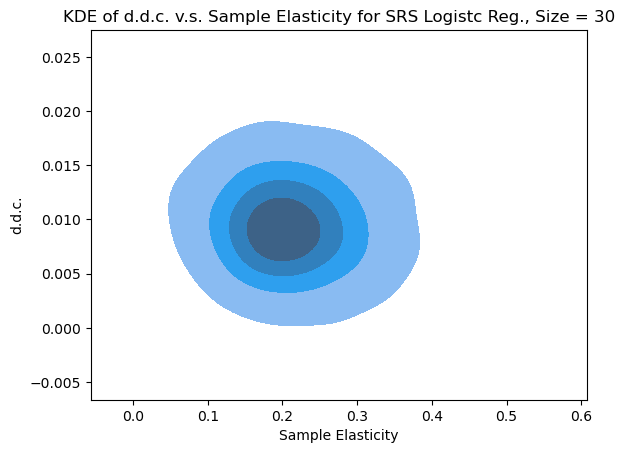

In [61]:
sns.kdeplot(all_data_per_ss[all_data_per_ss['sample_size'] == temp_sample_size], y='ddc', x = 'jn', \
            levels=5, bw_adjust=1.8, fill=True)
plt.title(f'KDE of d.d.c. v.s. Sample Elasticity for SRS Logistc Reg., Size = {temp_sample_size}')
plt.xlabel('Sample Elasticity')
plt.ylabel('d.d.c.')
plt.savefig(f'kde_logistic_ddc_vs_elasticity_biased_logistic_sample_{temp_sample_size}.png')

##### plot out the mean + 2x stdev:

In [189]:
mean_per_ss = all_data_per_ss.groupby(by='sample_size')['sq_ddc_div_sq_jn'].mean()
stdev_per_ss = all_data_per_ss.groupby(by='sample_size')['sq_ddc_div_sq_jn'].std()

In [193]:
mean_and_stdev = pd.concat([mean_per_ss, stdev_per_ss], axis=1)

In [194]:
mean_and_stdev.columns = ['mean', 'std']

In [205]:
mean_and_stdev['mean + 2 std'] = mean_and_stdev['mean'] + 2 * mean_and_stdev['std'] / np.sqrt(1000)
mean_and_stdev['mean - 2 std'] = mean_and_stdev['mean'] - 2 * mean_and_stdev['std'] / np.sqrt(1000)

In [206]:
mean_and_stdev = mean_and_stdev.reset_index()

In [207]:
mean_and_stdev['Log10 Sample Size'] = np.log10(mean_and_stdev['sample_size'])

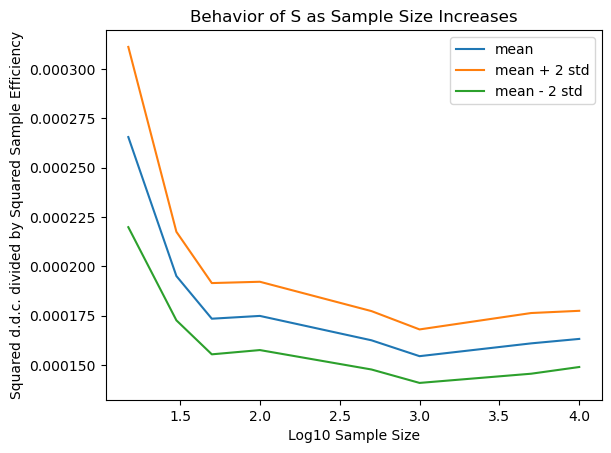

In [209]:
mean_and_stdev.set_index(['Log10 Sample Size'])[['mean', 'mean + 2 std', 'mean - 2 std']].plot()
plt.ylabel(f'Squared d.d.c. divided by Squared Sample Efficiency')
plt.xlabel('Log10 Sample Size')
plt.title(f'Behavior of S as Sample Size Increases')
plt.savefig('S_behavior_pop_100_000.png', bbox_inches='tight')

##### plot out the distribution:

In [184]:
quantiles_to_show = [5, 25, 50, 75, 90, 95]
# quantiles_to_show = [5, 50, 95]

quantiled_cond_vals = all_data_per_ss.groupby(by='sample_size').quantile(q=np.array(quantiles_to_show) / 100).reset_index()

In [145]:
quantiled_cond_vals

,sample_size,level_1,ddc,jn,sq_ddc,sq_jn,ddc_div_jn,sq_ddc_div_sq_jn
0,15,0.05,-0.004979,0.111035,2.564757e-08,0.012329,5.779550e-07,5.779550e-07
1,15,0.25,-0.001910,0.176187,9.423748e-07,0.031042,1.909615e-05,1.909615e-05
2,15,0.50,0.000156,0.225756,4.465335e-06,0.050966,9.182696e-05,9.182696e-05
3,15,0.75,0.002230,0.285747,1.214580e-05,0.081651,2.626787e-04,2.626787e-04
4,15,0.90,0.003763,0.349486,2.488710e-05,0.122140,5.765412e-04,5.765412e-04
5,15,0.95,0.004988,0.388221,3.863183e-05,0.150716,9.767774e-04,9.767774e-04
6,30,0.05,-0.005261,0.153607,3.304922e-08,0.023595,6.686985e-07,6.686985e-07
7,30,0.25,-0.002006,0.198390,8.003180e-07,0.039359,1.587191e-05,1.587191e-05
8,30,0.50,-0.000063,0.236376,4.228884e-06,0.055874,7.229968e-05,7.229968e-05
9,30,0.75,0.002087,0.280050,1.209339e-05,0.078428,2.322584e-04,2.322584e-04


In [166]:
pivoted_cond_vals = quantiled_cond_vals.pivot(index='sample_size', columns='level_1', values=f'sq_ddc_div_sq_jn')

In [167]:
pivoted_cond_vals

level_1,0.05,0.25,0.50,0.75,0.90,0.95
sample_size,,,,,,
15,5.779550e-07,0.000019,0.000092,0.000263,0.000577,0.000977
30,6.686985e-07,0.000016,0.000072,0.000232,0.000507,0.000759
50,7.778773e-07,0.000017,0.000069,0.000209,0.000472,0.000650
100,6.712944e-07,0.000016,0.000067,0.000205,0.000463,0.000701
500,6.886338e-07,0.000017,0.000076,0.000208,0.000452,0.000630
1000,3.572123e-07,0.000015,0.000070,0.000206,0.000429,0.000611
5000,5.871648e-07,0.000015,0.000070,0.000216,0.000460,0.000680
10000,6.194214e-07,0.000019,0.000076,0.000226,0.000436,0.000603


In [168]:
pivoted_cond_vals = pivoted_cond_vals.reset_index()

pivoted_cond_vals.columns = ['Log Sample Size'] + [f'{i}th Perc.' for i in quantiles_to_show]

Text(0.5, 1.0, 'Behavior of S as Sample Size Increases')

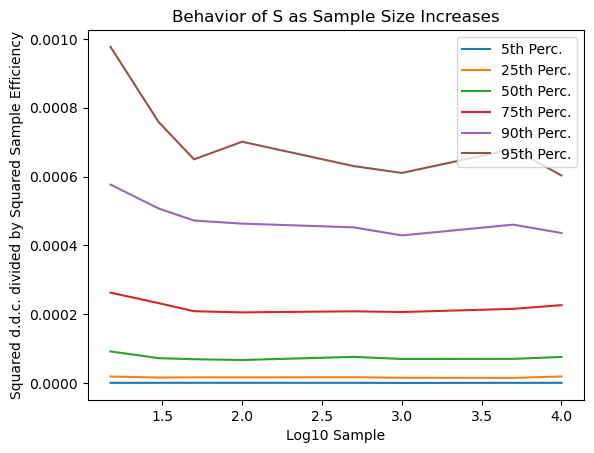

In [169]:
pivoted_cond_vals['Log Sample Size'] = np.log10(pivoted_cond_vals['Log Sample Size'])
pivoted_cond_vals.set_index('Log Sample Size').plot()
plt.ylabel(f'Squared d.d.c. divided by Squared Sample Efficiency')
plt.xlabel('Log10 Sample')
plt.title(f'Behavior of S as Sample Size Increases')

In [ ]:
    plt.savefig(f'biased_ddc_{i}_{specific_model_type}.png',
bbox_inches='tight')

#### investigate problem of different mean of score functions:

In [57]:
population_size = 10_000_000

In [52]:
pop_data = generate_population_data(population_size, number_of_coefficients, 
                                    feature_cols = feature_cols, true_beta = true_beta)
pop_x = pop_data[feature_cols]
pop_y = pop_data['y']

pop_model = sm.Logit(endog = pop_y, exog = pop_x).fit(disp=0)
pop_beta = np.array(pop_model.params)

pop_gs = pop_x * (np.array(pop_y).reshape((population_size, 1)) - \
              np.array(pop_model.predict()).reshape((population_size, 1)))

In [53]:
temp_pop_data = pop_data

In [54]:
temp_pop_data['eta'] = expit(temp_pop_data['x_0'])
temp_pop_data['score'] = temp_pop_data.eval('x_0 * (y - eta)')
temp_pop_data['neg_deriv_score'] = temp_pop_data.eval('(x_0 ** 2) * (1 - eta) * eta')

all_sample_data_for_score = []
for _ in trange(1_000):
    all_sample_data_for_score.append(temp_pop_data.sample(1_000)[['score', 'neg_deriv_score']].mean())


all_sample_data_for_score = pd.concat(all_sample_data_for_score, axis=1).T

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:59<00:00,  2.38it/s]


<Axes: xlabel='score', ylabel='neg_deriv_score'>

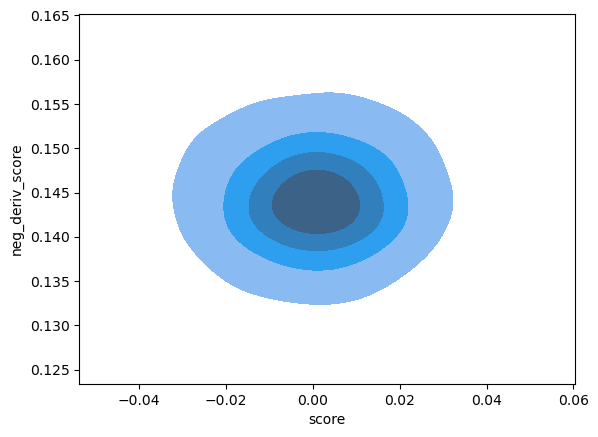

In [55]:
sns.kdeplot(data = all_sample_data_for_score, y='neg_deriv_score', \
            x = 'score', fill=True, bw_adjust=1.8, levels=5)

In [61]:
number_of_coefficients, true_beta, feature_cols

(1, 1, ['x_0'])

In [63]:
population_size = 1_000

In [64]:
all_sample_data_for_score = []
for _ in trange(1_000):
    temp_pop_data = generate_population_data(population_size, number_of_coefficients, 
                                    feature_cols = feature_cols, true_beta = true_beta)
    temp_pop_data['eta'] = expit(temp_pop_data['x_0'])
    temp_pop_data['score'] = temp_pop_data.eval('x_0 * (y - eta)')
    temp_pop_data['neg_deriv_score'] = temp_pop_data.eval('(x_0 ** 2) * (1 - eta) * eta')

    all_sample_data_for_score.append(temp_pop_data[['score', 'neg_deriv_score']].mean())


all_sample_data_for_score = pd.concat(all_sample_data_for_score, axis=1).T

100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 205.55it/s]


<Axes: xlabel='score', ylabel='neg_deriv_score'>

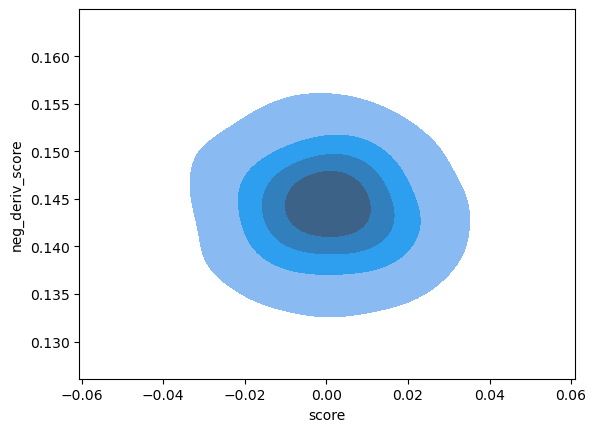

In [65]:
sns.kdeplot(data = all_sample_data_for_score, y='neg_deriv_score', \
            x = 'score', fill=True, bw_adjust=1.8, levels=5)